In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    precision_score,
mean_squared_error, mean_absolute_error, r2_score
)

from fit_adversarial import minority_logit_auc
from fairness_measures import *

df = pd.read_csv("all_vals_race1_interestrate1.csv")

df.drop(
    columns=[
        "Unnamed: 0",
        "IsTestData",
        "IsCalibrateData",
        "v1",
        "istestdata2",
        "iscalibratedata2",
    ],
    inplace=True,
)

df["minority"] = (
    (df["race_dum_Black"] == 1)
    | (df["race_dum_Native Am, Alaska, Hawaii"] == 1)
    | (df["race_dum_White hisp"] == 1)
    # | (df['race_dum_Asian'] == 1)
)

features = df.drop(
    columns=[
        "Default", "cur_int_rate", "sato", "minority",
        "race_dum_Unknown", "race_dum_Asian", "race_dum_Black",
        "race_dum_Native Am, Alaska, Hawaii", "race_dum_White hisp", "race_dum_White non-hisp"
    ],
    axis=1
)

target = df["cur_int_rate"]

features_numeric = pd.get_dummies(features, drop_first=True)

print(features_numeric.info())
print(features_numeric.describe())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16073 entries, 0 to 16072
Data columns (total 74 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   applicant_income        16073 non-null  float64
 1   ltv_ratio_fill          16073 non-null  float64
 2   fico_orig_miss          16073 non-null  int64  
 3   fico_orig_fill          16073 non-null  float64
 4   orig_amt                16073 non-null  int64  
 5   log_org_amt             16073 non-null  float64
 6   occupancy_type_dum_1    16073 non-null  int64  
 7   occupancy_type_dum_2    16073 non-null  int64  
 8   jumbo_flg_dum_n         16073 non-null  int64  
 9   investor_type_dum_1     16073 non-null  int64  
 10  investor_type_dum_2     16073 non-null  int64  
 11  investor_type_dum_3     16073 non-null  int64  
 12  loan_purpose_dum_1      16073 non-null  int64  
 13  loan_purpose_dum_2      16073 non-null  int64  
 14  coapplicant_dum_0       16073 non-null

In [ ]:
ols_model = sm.OLS(target, sm.add_constant(features_numeric))
result = ols_model.fit()
# print(result.summary())

y_pred = result.predict(sm.add_constant(features_numeric))

S, Y, A = prepare_data(y_pred, target, df["minority"])

independence, separation, sufficiency = train_classifiers(np.array(S), np.array(Y), np.array(A), False)

print(independence, separation, sufficiency)

base_stats = calculate_base_statistics(A)

print(base_stats)

normalized_metric = calculate_independence_metric(S, A, independence, base_stats)

(LogisticRegression(max_iter=1000), 0.22472964253450306) (LogisticRegression(max_iter=1000), 0.2252977375317215) (LogisticRegression(max_iter=1000), 0.22453480894570724)
{'P(A=0)': 0.9402102905493686, 'P(A=1)': 0.059789709450631494, 'H[A]': 0.2263885081584557}


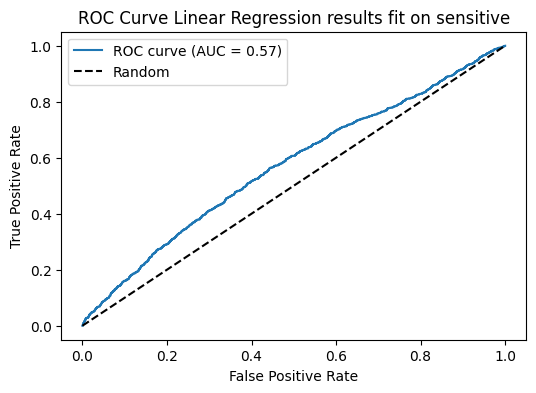

In [4]:
lr_full = LinearRegression()
lr_full.fit(features_numeric, target)

y_pred_lr = lr_full.predict(features_numeric)

auc = minority_logit_auc(y_pred_lr, df["minority"], name="ROC Curve Linear Regression results fit on sensitive")

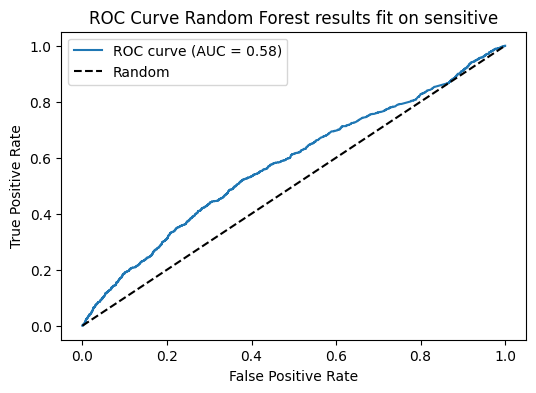

In [5]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    random_state=42,
    max_depth=7,
    min_samples_leaf=10,
    n_estimators=100,
)
rf.fit(features_numeric, target)

y_pred_rf = rf.predict(features_numeric)

auc = minority_logit_auc(y_pred_rf, df["minority"], name="ROC Curve Random Forest results fit on sensitive")

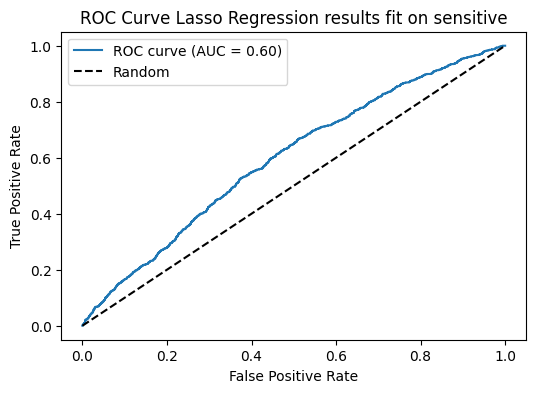

Lasso minority AUC: 0.5965727149183426


In [6]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)
lasso.fit(features_numeric, target)

y_pred_lasso = lasso.predict(features_numeric)

auc_lasso = minority_logit_auc(
    y_pred_lasso, df["minority"], name="ROC Curve Lasso Regression results fit on sensitive"
)
print("Lasso minority AUC:", auc_lasso)

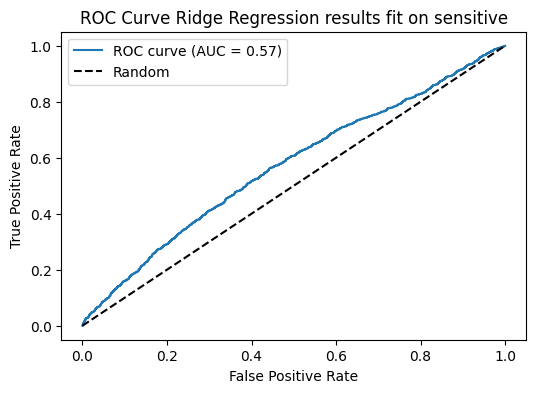

In [7]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.1)
ridge.fit(features_numeric, target)

y_pred_ridge = ridge.predict(features_numeric)

auc_ridge = minority_logit_auc(
    y_pred_ridge, df["minority"], name="ROC Curve Ridge Regression results fit on sensitive"
)

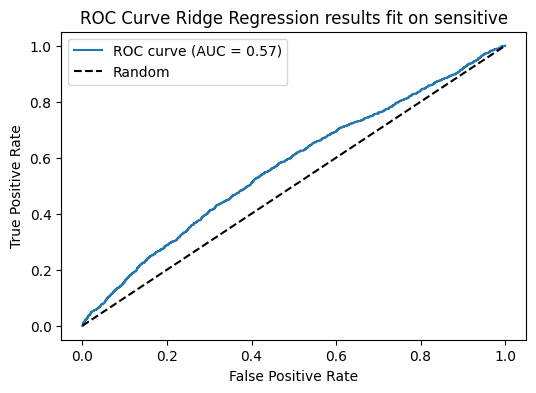

In [8]:
from sklearn.linear_model import ElasticNet

elastic = ElasticNet(alpha=0.001)
elastic.fit(features_numeric, target)

y_pred_elastic = elastic.predict(features_numeric)

auc_elastic = minority_logit_auc(
    y_pred_elastic, df["minority"], name="ROC Curve Ridge Regression results fit on sensitive"
)

In [9]:
# Standardize predicted rates, fit Logit minority ~ standardized_rate, collect coef, p-value, effect size, AUC

pred_dict = {
    "OLS": y_pred,                 # Series
    "LinearRegression": y_pred_lr, # np.ndarray
    "RandomForest": y_pred_rf      # np.ndarray
}

results_rows = []
logit_race_models = {}

for model_name, preds in pred_dict.items():
    preds_arr = np.asarray(preds)
    z_rate = (preds_arr - preds_arr.mean()) / preds_arr.std(ddof=0)
    X = sm.add_constant(pd.Series(z_rate, name="z_rate"))
    logit_fit = sm.Logit(df["minority"], X).fit(disp=0)
    logit_race_models[model_name] = logit_fit

    coef = logit_fit.params["z_rate"]
    se_ = logit_fit.bse["z_rate"]
    pval = logit_fit.pvalues["z_rate"]
    odds_ratio = np.exp(coef)
    auc_val = roc_auc_score(df["minority"], preds_arr)

    # Since predictor is standardized, coef = change in log-odds per 1 SD; odds_ratio likewise per 1 SD
    results_rows.append({
        "model": model_name,
        "coef_log_odds_per_SD": coef,
        "std_err": se_,
        "p_value": pval,
        "odds_ratio_per_SD": odds_ratio,
        "AUC_race_from_rate": auc_val
    })

race_inference_results = pd.DataFrame(results_rows).sort_values("AUC_race_from_rate", ascending=False)
print(race_inference_results)

# Optional: show a brief interpretation for each model
for _, r in race_inference_results.iterrows():
    print(
        f"{r.model}: AUC={r.AUC_race_from_rate:.3f}, odds ratio per 1 SD rate increase = {r.odds_ratio_per_SD:.3f}, "
        f"coef={r.coef_log_odds_per_SD:.3f}, p={r.p_value:.3g}"
    )

              model  coef_log_odds_per_SD   std_err       p_value  \
2      RandomForest              0.262790  0.032569  7.109567e-16   
0               OLS              0.246408  0.034009  4.310703e-13   
1  LinearRegression              0.246408  0.034009  4.310703e-13   

   odds_ratio_per_SD  AUC_race_from_rate  
2           1.300554            0.577999  
0           1.279422            0.569934  
1           1.279422            0.569934  
RandomForest: AUC=0.578, odds ratio per 1 SD rate increase = 1.301, coef=0.263, p=7.11e-16
OLS: AUC=0.570, odds ratio per 1 SD rate increase = 1.279, coef=0.246, p=4.31e-13
LinearRegression: AUC=0.570, odds ratio per 1 SD rate increase = 1.279, coef=0.246, p=4.31e-13
